# Project Map / Rubric Map

- EDA (4 variables + business interpretation) → `# EDA (Core)` and `## EDA (Extension)`
- Feature Engineering (≥4 features + economic rationale) → `## Feature Engineering (Economic Intuition)`
- Train/Validation/Test usage (no leakage) → `## Train/Validation/Test Strategy (No Leakage)`
- Models 0–3 + feature importance → `## Models (0–3)` and sub‑sections for each model
- Model comparison → `## Model Comparison`
- Threshold optimization (business) → `## Threshold Optimization (Business)`
- Final test evaluation → `## Final Test Evaluation`
- Conclusion → `## Conclusion`

How to run: Restart Kernel & Run All.


## Objective & Dataset

This notebook builds a supervised credit risk model to estimate default probability from historical loan data, following the course workflow and rubric.


In [ ]:
# Config
RANDOM_STATE = 42
TARGET_COL = "default"
ID_COL = "id"
TRAIN_PATH = "../data/lending_club_train.csv"
TEST_PATH = "../data/lending_club_test.csv"

# Placeholder for later phases: resolve repo-root outputs/ path here.
# OUTPUT_DIR_RESOLUTION = None

PAYOFF = {
    "TN": 1,
    "FP": -1,
    "FN": -5,
    "TP": 0,
}


In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

from sklearn.metrics import mean_squared_error, roc_auc_score, roc_curve, confusion_matrix

pd.set_option("display.max_columns", 200)


## Data Loading


In [ ]:
df_train = pd.read_csv(TRAIN_PATH)
df_test = pd.read_csv(TEST_PATH)

df_train.shape, df_test.shape


((10129, 21), (2533, 21))

## Data Quality & Target Balance


In [ ]:
assert TARGET_COL in df_train.columns
assert set(np.unique(df_train[TARGET_COL])).issubset({0, 1})

df_train[TARGET_COL].value_counts(normalize=True)


## Variable Types

| Variable name | Variable type | Why it matters for credit risk |
| --- | --- | --- |
| int_rate | numerical (continuous) | Higher rates often reflect higher borrower risk and expected loss. |
| dti | numerical (continuous) | Higher debt-to-income suggests tighter cash flow and default risk. |
| loan_amnt | numerical (continuous) | Larger loans increase exposure and repayment burden. |
| grade | categorical (ordinal) | Encodes lender risk grading tied to expected default levels. |


## EDA (Core)


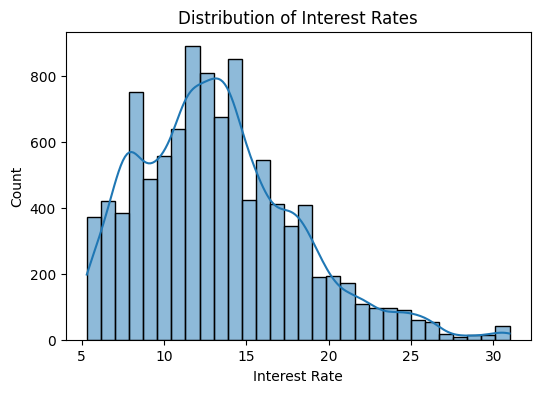

In [3]:
plt.figure(figsize=(6,4))
sns.histplot(df_train["int_rate"], bins=30, kde=True)
plt.title("Distribution of Interest Rates")
plt.xlabel("Interest Rate")
plt.ylabel("Count")
plt.show()


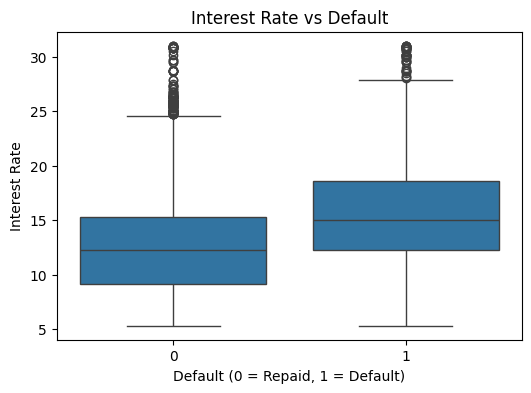

In [4]:
plt.figure(figsize=(6,4))
sns.boxplot(x="default", y="int_rate", data=df_train)
plt.title("Interest Rate vs Default")
plt.xlabel("Default (0 = Repaid, 1 = Default)")
plt.ylabel("Interest Rate")
plt.show()


**Interest Rate (`int_rate`)**

The interest rate reflects the lender’s assessment of borrower risk at origination.
The distribution shows a wide range of rates, with higher interest rates being more frequent among loans that eventually defaulted.
This suggests that interest rates already embed risk information and are strongly associated with default probability.


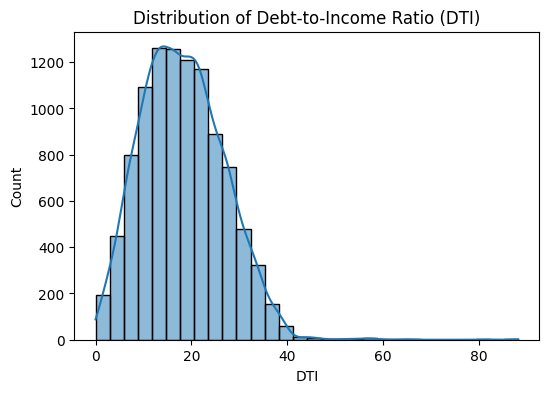

In [5]:
plt.figure(figsize=(6,4))
sns.histplot(df_train["dti"], bins=30, kde=True)
plt.title("Distribution of Debt-to-Income Ratio (DTI)")
plt.xlabel("DTI")
plt.ylabel("Count")
plt.show()


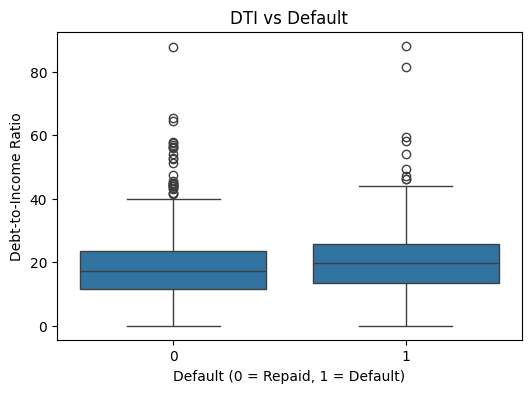

In [6]:
plt.figure(figsize=(6,4))
sns.boxplot(x="default", y="dti", data=df_train)
plt.title("DTI vs Default")
plt.xlabel("Default (0 = Repaid, 1 = Default)")
plt.ylabel("Debt-to-Income Ratio")
plt.show()


**Debt-to-Income Ratio (`dti`)**

The debt-to-income ratio measures the proportion of a borrower’s income already committed to debt obligations.
Higher DTI values indicate greater financial strain and reduced repayment capacity.
The analysis shows that defaulted loans tend to have higher DTI levels, confirming DTI as a key risk driver in credit decisions.


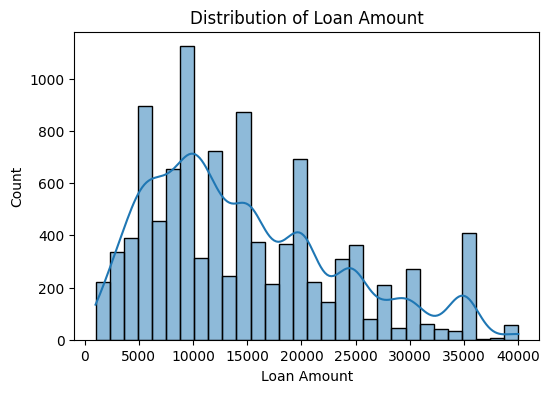

In [7]:
plt.figure(figsize=(6,4))
sns.histplot(df_train["loan_amnt"], bins=30, kde=True)
plt.title("Distribution of Loan Amount")
plt.xlabel("Loan Amount")
plt.ylabel("Count")
plt.show()


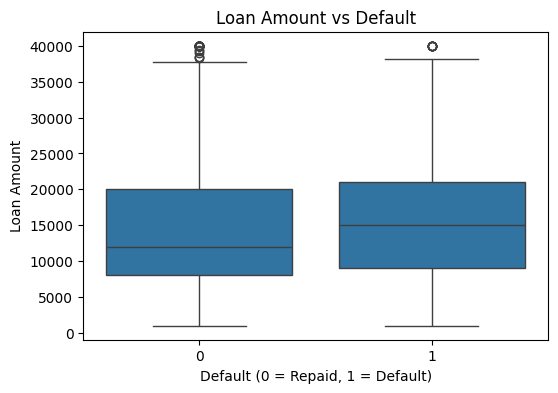

In [8]:
plt.figure(figsize=(6,4))
sns.boxplot(x="default", y="loan_amnt", data=df_train)
plt.title("Loan Amount vs Default")
plt.xlabel("Default (0 = Repaid, 1 = Default)")
plt.ylabel("Loan Amount")
plt.show()


**Loan Amount (`loan_amnt`)**

The loan amount represents the size of the lender’s exposure rather than the borrower’s intrinsic credit quality.
The distribution shows a concentration around mid-sized loans.
The relationship with default appears weaker than for interest rate or DTI, suggesting that loan size alone is not a primary driver of default, but may interact with income or other risk factors.


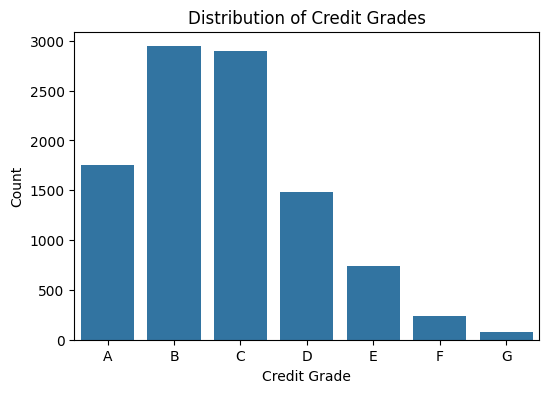

In [9]:
plt.figure(figsize=(6,4))
sns.countplot(x="grade", data=df_train, order=sorted(df_train["grade"].unique()))
plt.title("Distribution of Credit Grades")
plt.xlabel("Credit Grade")
plt.ylabel("Count")
plt.show()


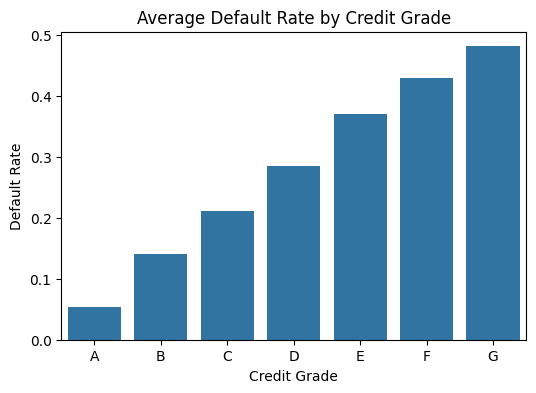

In [10]:
grade_default_rate = (
    df_train
    .groupby("grade")["default"]
    .mean()
    .reset_index()
)

plt.figure(figsize=(6,4))
sns.barplot(x="grade", y="default", data=grade_default_rate,
            order=sorted(grade_default_rate["grade"]))
plt.title("Average Default Rate by Credit Grade")
plt.xlabel("Credit Grade")
plt.ylabel("Default Rate")
plt.show()


**Credit Grade (`grade`)**

The credit grade is an ordinal categorical variable summarizing the lender’s internal credit assessment at origination.
Lower grades are associated with significantly higher default rates, while higher grades exhibit substantially lower default frequencies.
This clear monotonic relationship confirms that `grade` is one of the strongest predictors of default and validates its economic relevance in credit risk modeling.


## EDA (Extension)


In [11]:
# Select numerical columns only
num_cols = df_train.select_dtypes(include=[np.number]).columns.tolist()

# Exclude target itself
num_cols = [c for c in num_cols if c != "default"]

num_cols


['id',
 'loan_amnt',
 'term',
 'int_rate',
 'installment',
 'annual_inc',
 'emp_length',
 'dti',
 'delinq_2yrs',
 'inq_last_6mths',
 'open_acc',
 'pub_rec',
 'revol_bal',
 'revol_util',
 'total_acc']

In [12]:
corr_with_target = (
    df_train[num_cols + ["default"]]
    .corr()["default"]
    .drop("default")
    .sort_values(ascending=False)
)

corr_with_target.to_frame(name="Correlation with Default")


,Correlation with Default
int_rate,0.251016
term,0.169246
dti,0.102043
inq_last_6mths,0.073969
revol_util,0.072172
loan_amnt,0.068005
installment,0.054795
id,0.042234
pub_rec,0.037639
delinq_2yrs,0.017844


## Feature Engineering (Economic Intuition)

### Feature Engineering Strategy

Feature engineering was guided by economic intuition rather than brute-force expansion. Engineered variables capture distinct borrower-risk dimensions: affordability/burden, leverage/utilization, credit experience/stability, and nonlinear effects, while maintaining interpretability and model stability.

| Feature | Intuition |
| --- | --- |
| installment_to_income | installment / annual_inc |
| loan_to_income | loan_amnt / annual_inc |
| revol_balance_util | revol_bal * revol_util |
| revol_balance_to_income | revol_bal / annual_inc |
| open_to_total_acc | open_acc / total_acc |
| recent_inquiry_flag | (inq_last_6mths > 0) |
| log_annual_inc | log(annual_inc) |
| sqrt_dti | sqrt(dti) |


In [ ]:
ID_COL = "id" if "id" in df_train.columns else None

y = df_train[TARGET_COL].astype(int)
X = df_train.drop(columns=[TARGET_COL] + ([ID_COL] if ID_COL else []))

if ID_COL is not None:
    assert ID_COL not in X.columns

X_test_final = df_test.drop(columns=([ID_COL] if ID_COL and ID_COL in df_test.columns else []))


In [14]:
def add_engineered_features(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()

    annual_inc_safe = df["annual_inc"].clip(lower=1)
    total_acc_safe = df["total_acc"].replace(0, np.nan)

    df["installment_to_income"] = df["installment"] / annual_inc_safe
    df["loan_to_income"] = df["loan_amnt"] / annual_inc_safe
    df["revol_balance_util"] = df["revol_bal"] * df["revol_util"]
    df["revol_balance_to_income"] = df["revol_bal"] / annual_inc_safe
    df["open_to_total_acc"] = df["open_acc"] / total_acc_safe
    df["recent_inquiry_flag"] = (df["inq_last_6mths"] > 0).astype(int)
    df["log_annual_inc"] = np.log(annual_inc_safe)
    df["sqrt_dti"] = np.sqrt(df["dti"].clip(lower=0))

    return df

engineered_cols = [
    "installment_to_income",
    "loan_to_income",
    "revol_balance_util",
    "revol_balance_to_income",
    "open_to_total_acc",
    "recent_inquiry_flag",
    "log_annual_inc",
    "sqrt_dti",
]

X_fe = add_engineered_features(X)
X_test_fe = add_engineered_features(X_test_final)


In [15]:
print("Engineered columns:", engineered_cols)

X_fe[engineered_cols].describe().T[["mean", "std", "min", "max"]]

X_fe[engineered_cols].isna().mean().sort_values(ascending=False)


Engineered columns: ['installment_to_income', 'loan_to_income', 'revol_balance_util', 'revol_balance_to_income', 'open_to_total_acc', 'recent_inquiry_flag', 'log_annual_inc', 'sqrt_dti']


installment_to_income      0.0
loan_to_income             0.0
revol_balance_util         0.0
revol_balance_to_income    0.0
open_to_total_acc          0.0
recent_inquiry_flag        0.0
log_annual_inc             0.0
sqrt_dti                   0.0
dtype: float64

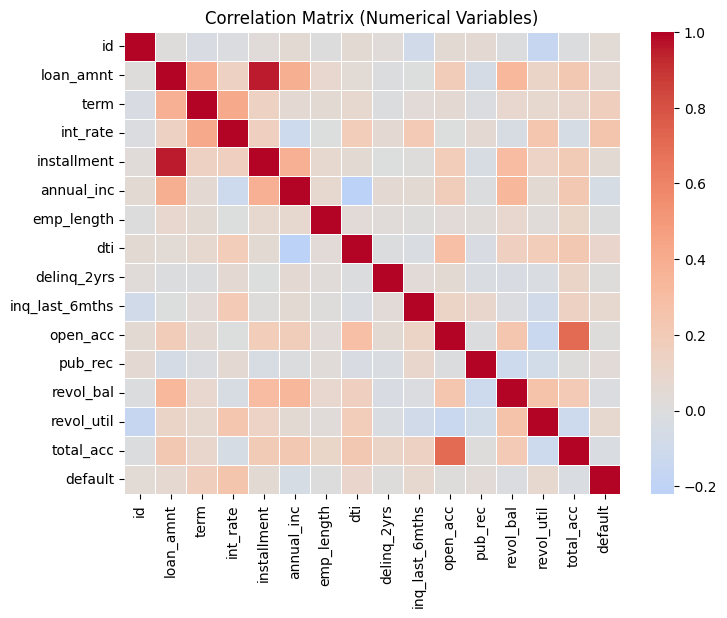

In [16]:
plt.figure(figsize=(8,6))
sns.heatmap(
    df_train[num_cols + ["default"]].corr(),
    cmap="coolwarm",
    center=0,
    linewidths=0.5
)
plt.title("Correlation Matrix (Numerical Variables)")
plt.show()


**Correlation with Default (Numerical Variables)**

As an extension of the initial EDA, we examine linear correlations between numerical variables and the default indicator.
Variables such as interest rate and debt-to-income ratio show stronger positive correlations with default, while income-related variables tend to be negatively correlated.
These results are consistent with economic intuition and support the relevance of these variables for credit risk modeling.


In [17]:
df_train["dti_quartile"] = pd.qcut(df_train["dti"], q=4, labels=["Q1 (Low)", "Q2", "Q3", "Q4 (High)"])


In [18]:
dti_default_by_quantile = (
    df_train
    .groupby("dti_quartile", observed=False)["default"]
    .mean()
    .reset_index()
)

dti_default_by_quantile


,dti_quartile,default
0,Q1 (Low),0.151599
1,Q2,0.161672
2,Q3,0.212732
3,Q4 (High),0.245358


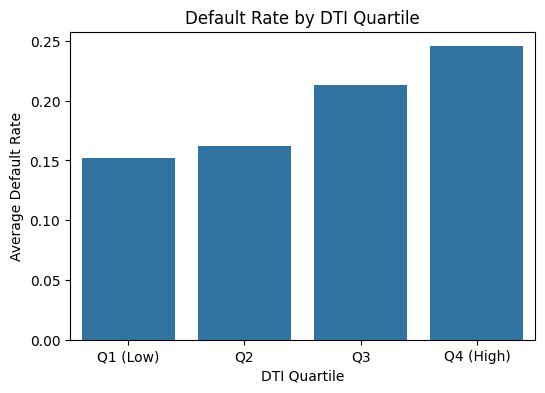

In [19]:
plt.figure(figsize=(6,4))
sns.barplot(
    x="dti_quartile",
    y="default",
    data=dti_default_by_quantile
)
plt.title("Default Rate by DTI Quartile")
plt.xlabel("DTI Quartile")
plt.ylabel("Average Default Rate")
plt.show()


**Default Rate by DTI Quantiles**

To capture potential nonlinear effects, we analyze default rates across quartiles of the debt-to-income ratio.
Default probability increases monotonically from the lowest to the highest DTI quartile, indicating that borrower risk rises disproportionately at higher levels of indebtedness.
This supports the inclusion of nonlinear transformations or interaction-based features in subsequent modeling steps.


In [20]:
df_train.drop(columns=["dti_quartile"], inplace=True)


In [21]:
df_train.head()


,id,loan_amnt,term,int_rate,installment,grade,sub_grade,annual_inc,emp_length,home_ownership,verification_status,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,purpose,default
0,79044496,16000.0,60.0,12.99,363.97,C,C2,49000.0,5.0,RENT,Source Verified,15.94,0.0,0.0,9.0,0.0,26376.0,85.4,19.0,debt_consolidation,0
1,43246030,15150.0,36.0,10.99,495.92,B,B4,38000.0,8.0,MORTGAGE,Not Verified,39.96,1.0,1.0,10.0,0.0,19459.0,63.2,38.0,credit_card,0
2,641694,12800.0,60.0,14.83,303.38,D,D3,75000.0,0.0,RENT,Source Verified,12.43,0.0,0.0,12.0,0.0,8078.0,35.0,13.0,moving,0
3,70981628,6000.0,36.0,9.75,192.90,B,B3,70000.0,0.0,MORTGAGE,Verified,25.53,1.0,1.0,9.0,0.0,2048.0,39.4,16.0,debt_consolidation,0
4,57792301,15000.0,60.0,13.33,343.84,C,C3,96000.0,3.0,RENT,Source Verified,13.44,0.0,0.0,11.0,1.0,15979.0,53.3,36.0,debt_consolidation,0


In [22]:
df_train.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10129 entries, 0 to 10128
Data columns (total 21 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   10129 non-null  int64  
 1   loan_amnt            10129 non-null  float64
 2   term                 10129 non-null  float64
 3   int_rate             10129 non-null  float64
 4   installment          10129 non-null  float64
 5   grade                10129 non-null  object 
 6   sub_grade            10129 non-null  object 
 7   annual_inc           10129 non-null  float64
 8   emp_length           10129 non-null  float64
 9   home_ownership       10129 non-null  object 
 10  verification_status  10129 non-null  object 
 11  dti                  10129 non-null  float64
 12  delinq_2yrs          10129 non-null  float64
 13  inq_last_6mths       10129 non-null  float64
 14  open_acc             10129 non-null  float64
 15  pub_rec              10129 non-null 

In [23]:
df_train.dtypes


id                       int64
loan_amnt              float64
term                   float64
int_rate               float64
installment            float64
grade                   object
sub_grade               object
annual_inc             float64
emp_length             float64
home_ownership          object
verification_status     object
dti                    float64
delinq_2yrs            float64
inq_last_6mths         float64
open_acc               float64
pub_rec                float64
revol_bal              float64
revol_util             float64
total_acc              float64
purpose                 object
default                  int64
dtype: object

## Train/Validation/Test Strategy (No Leakage)

Training uses only `X_train`/`y_train`, validation is used for tuning, and the test set is held out for final evaluation. `X_test_final` is never used in any model `.fit()` calls.


## Models (0–3)


Tuning grids are intentionally small to ensure fast execution and reproducible results.


## Model 0 — Logistic Regression (Baseline)

This baseline provides a simple, interpretable benchmark for credit risk prediction. Logistic Regression serves as a linear reference point for comparison with more complex models.


In [24]:
X_train, X_val, y_train, y_val = train_test_split(
    X_fe,
    y,
    test_size=0.25,
    stratify=y,
    random_state=RANDOM_STATE,
)


In [ ]:
assert X_test_final is not X_train
assert X_test_final is not X_val


In [25]:
categorical_cols = X_train.select_dtypes(include=["object"]).columns.tolist()
num_cols = [c for c in X_train.columns if c not in categorical_cols]

numeric_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
    ]
)

categorical_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(handle_unknown="ignore")),
    ]
)

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_cols),
        ("cat", categorical_transformer, categorical_cols),
    ]
)


In [ ]:
log_reg = LogisticRegression(
    solver="lbfgs",
    max_iter=1000,
    random_state=RANDOM_STATE,
)

log_reg_pipeline = Pipeline(
    steps=[
        ("preprocess", preprocess),
        ("model", log_reg),
    ]
)

log_reg_pipeline.fit(X_train, y_train)
print("Pipeline fitted. Preprocess: num + cat. Model: LogisticRegression.")

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('preprocess', ...), ('model', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('num', ...), ('cat', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transformers cont

In [ ]:
def evaluate_model(model_name, pipeline, X_train, y_train, X_val, y_val):
    train_probs = pipeline.predict_proba(X_train)[:, 1]
    val_probs = pipeline.predict_proba(X_val)[:, 1]

    train_rmse = np.sqrt(mean_squared_error(y_train, train_probs))
    val_rmse = np.sqrt(mean_squared_error(y_val, val_probs))

    train_auc = roc_auc_score(y_train, train_probs)
    val_auc = roc_auc_score(y_val, val_probs)

    return {
        "Model": model_name,
        "Train_RMSE": train_rmse,
        "Val_RMSE": val_rmse,
        "Train_AUC": train_auc,
        "Val_AUC": val_auc,
        "AUC_Gap": train_auc - val_auc,
        "RMSE_Gap": val_rmse - train_rmse,
    }

results_df = pd.DataFrame()


In [ ]:
log_reg_metrics = evaluate_model(
    "Logistic Regression",
    log_reg_pipeline,
    X_train,
    y_train,
    X_val,
    y_val,
)

results_df = pd.concat([results_df, pd.DataFrame([log_reg_metrics])], ignore_index=True)

results_df


,Model,Dataset,RMSE,AUC
0,Logistic Regression,Train,0.374962,0.712319
1,Logistic Regression,Validation,0.379806,0.690397


## Model 1 — Decision Tree (Tuned)

Decision Trees capture nonlinearities and interactions among borrower characteristics. Because they can overfit, we tune key hyperparameters using the validation set.


In [28]:
categorical_cols_tree = X_train.select_dtypes(include=["object"]).columns.tolist()
num_cols_tree = [c for c in X_train.columns if c not in categorical_cols_tree]

numeric_transformer_tree = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="median")),
    ]
)

categorical_transformer_tree = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(handle_unknown="ignore")),
    ]
)

preprocess_tree = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer_tree, num_cols_tree),
        ("cat", categorical_transformer_tree, categorical_cols_tree),
    ]
)


In [ ]:
param_grid = {
    "max_depth": [3, 5, 7, 10],
    "min_samples_leaf": [50, 100, 200],
}

dt_tuning_results = []

for max_depth in param_grid["max_depth"]:
    for min_samples_leaf in param_grid["min_samples_leaf"]:
        tree_model = DecisionTreeClassifier(
            max_depth=max_depth,
            min_samples_leaf=min_samples_leaf,
            random_state=RANDOM_STATE,
        )

        tree_pipeline = Pipeline(
            steps=[
                ("preprocess", preprocess_tree),
                ("model", tree_model),
            ]
        )

        tree_pipeline.fit(X_train, y_train)
        train_probs = tree_pipeline.predict_proba(X_train)[:, 1]
        val_probs = tree_pipeline.predict_proba(X_val)[:, 1]

        dt_tuning_results.append(
            {
                "max_depth": max_depth,
                "min_samples_leaf": min_samples_leaf,
                "train_auc": roc_auc_score(y_train, train_probs),
                "val_auc": roc_auc_score(y_val, val_probs),
                "chosen_flag": False,
            }
        )

dt_tuning_df = pd.DataFrame(dt_tuning_results)

best_dt_idx = dt_tuning_df["val_auc"].idxmax()
dt_tuning_df.loc[best_dt_idx, "chosen_flag"] = True
best_dt_params = dt_tuning_df.loc[best_dt_idx, ["max_depth", "min_samples_leaf"]].to_dict()

# Keep compatibility with prior naming
best_params = best_dt_params
tuning_df = dt_tuning_df

dt_tuning_df.sort_values("val_auc", ascending=False).head(10)


,max_depth,min_samples_leaf,val_auc
0,3,50,0.667967
1,3,100,0.667967
2,3,200,0.667967
11,10,200,0.659281
8,7,200,0.659281
3,5,50,0.656571
5,5,200,0.656276
4,5,100,0.654881
7,7,100,0.648326
10,10,100,0.646720


In [ ]:
best_params = tuning_df.loc[tuning_df["val_auc"].idxmax()].to_dict()

best_tree = DecisionTreeClassifier(
    max_depth=int(best_params["max_depth"]),
    min_samples_leaf=int(best_params["min_samples_leaf"]),
    random_state=RANDOM_STATE,
)

best_tree_pipeline = Pipeline(
    steps=[
        ("preprocess", preprocess_tree),
        ("model", best_tree),
    ]
)

best_tree_pipeline.fit(X_train, y_train)
print("Pipeline fitted. Preprocess: num + cat. Model: DecisionTreeClassifier.")

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('preprocess', ...), ('model', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('num', ...), ('cat', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transformers cont

In [ ]:
dt_metrics = evaluate_model(
    "Decision Tree",
    best_tree_pipeline,
    X_train,
    y_train,
    X_val,
    y_val,
)

results_df = pd.concat([results_df, pd.DataFrame([dt_metrics])], ignore_index=True)

results_df


,Model,Dataset,RMSE,AUC
0,Logistic Regression,Train,0.374962,0.712319
1,Logistic Regression,Validation,0.379806,0.690397
2,Decision Tree,Train,0.379684,0.689931
3,Decision Tree,Validation,0.383817,0.667967


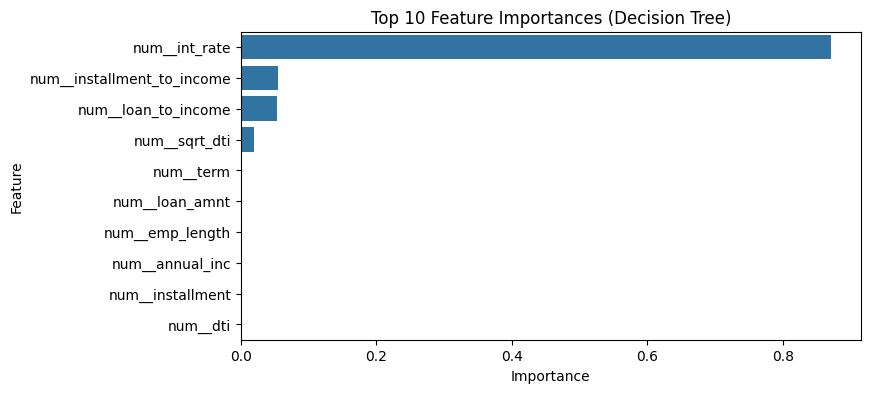

In [32]:
feature_names = best_tree_pipeline.named_steps["preprocess"].get_feature_names_out()
importances = best_tree_pipeline.named_steps["model"].feature_importances_

importance_df = pd.DataFrame(
    {"feature": feature_names, "importance": importances}
).sort_values("importance", ascending=False)

plt.figure(figsize=(8, 4))
sns.barplot(
    x="importance",
    y="feature",
    data=importance_df.head(10),
    orient="h",
)
plt.title("Top 10 Feature Importances (Decision Tree)")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()


## Model 2 — Random Forest (Bagging)

Random Forest reduces variance via bagging and feature subsampling.


In [ ]:
categorical_cols_rf = X_train.select_dtypes(include=["object"]).columns.tolist()
num_cols_rf = [c for c in X_train.columns if c not in categorical_cols_rf]

numeric_transformer_rf = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="median")),
    ]
)

categorical_transformer_rf = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(handle_unknown="ignore")),
    ]
)

preprocess_rf = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer_rf, num_cols_rf),
        ("cat", categorical_transformer_rf, categorical_cols_rf),
    ]
)

rf_grid = {
    "n_estimators": [200, 500],
    "max_depth": [None, 5, 10],
    "min_samples_leaf": [1, 20, 50],
    "max_features": ["sqrt", 0.5],
}

rf_tuning_results = []

for n_estimators in rf_grid["n_estimators"]:
    for max_depth in rf_grid["max_depth"]:
        for min_samples_leaf in rf_grid["min_samples_leaf"]:
            for max_features in rf_grid["max_features"]:
                rf_model = RandomForestClassifier(
                    n_estimators=n_estimators,
                    max_depth=max_depth,
                    min_samples_leaf=min_samples_leaf,
                    max_features=max_features,
                    random_state=RANDOM_STATE,
                    n_jobs=-1,
                )

                rf_pipeline = Pipeline(
                    steps=[
                        ("preprocess", preprocess_rf),
                        ("model", rf_model),
                    ]
                )

                rf_pipeline.fit(X_train, y_train)
                val_probs = rf_pipeline.predict_proba(X_val)[:, 1]
                val_auc = roc_auc_score(y_val, val_probs)

                rf_tuning_results.append(
                    {
                        "n_estimators": n_estimators,
                        "max_depth": max_depth,
                        "min_samples_leaf": min_samples_leaf,
                        "max_features": max_features,
                        "val_auc": val_auc,
                        "chosen_flag": False,
                    }
                )

rf_tuning_df = pd.DataFrame(rf_tuning_results)
rf_tuning_df["depth_rank"] = rf_tuning_df["max_depth"].apply(lambda d: 999 if d is None else d)

rf_sorted = rf_tuning_df.sort_values(
    ["val_auc", "n_estimators", "depth_rank"],
    ascending=[False, True, True],
)

best_rf_idx = rf_sorted.index[0]
rf_tuning_df.loc[best_rf_idx, "chosen_flag"] = True
best_rf_params = rf_tuning_df.loc[
    best_rf_idx, ["n_estimators", "max_depth", "min_samples_leaf", "max_features"]
].to_dict()

rf_tuning_df = rf_tuning_df.drop(columns=["depth_rank"])

rf_tuning_df.sort_values("val_auc", ascending=False).head(10)

rf_best_model = RandomForestClassifier(
    n_estimators=int(best_rf_params["n_estimators"]),
    max_depth=best_rf_params["max_depth"],
    min_samples_leaf=int(best_rf_params["min_samples_leaf"]),
    max_features=best_rf_params["max_features"],
    random_state=RANDOM_STATE,
    n_jobs=-1,
)

rf_best_pipeline = Pipeline(
    steps=[
        ("preprocess", preprocess_rf),
        ("model", rf_best_model),
    ]
)

rf_best_pipeline.fit(X_train, y_train)
print("Pipeline fitted. Preprocess: num + cat. Model: RandomForestClassifier.")

rf_metrics = evaluate_model(
    "Random Forest",
    rf_best_pipeline,
    X_train,
    y_train,
    X_val,
    y_val,
)

results_df = pd.concat([results_df, pd.DataFrame([rf_metrics])], ignore_index=True)

results_df


,Model,Dataset,RMSE,AUC
0,Logistic Regression,Train,0.374962,0.712319
1,Logistic Regression,Validation,0.379806,0.690397
2,Decision Tree,Train,0.379684,0.689931
3,Decision Tree,Validation,0.383817,0.667967
4,Random Forest,Train,0.368074,0.777227
5,Random Forest,Validation,0.379638,0.693457


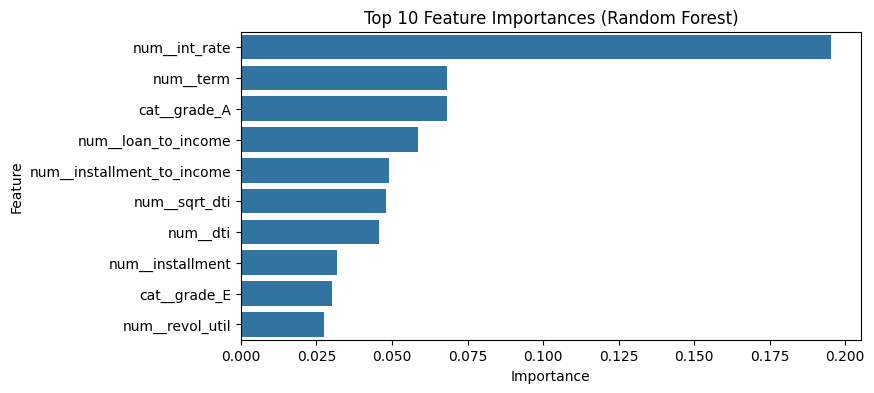

In [ ]:
rf_feature_names = rf_best_pipeline.named_steps["preprocess"].get_feature_names_out()
rf_importances = rf_best_pipeline.named_steps["model"].feature_importances_

rf_importance_df = pd.DataFrame(
    {"feature": rf_feature_names, "importance": rf_importances}
).sort_values("importance", ascending=False)

plt.figure(figsize=(8, 4))
sns.barplot(
    x="importance",
    y="feature",
    data=rf_importance_df.head(10),
    orient="h",
)
plt.title("Top 10 Feature Importances (Random Forest)")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()


## Model 3 — Gradient Boosting (Boosting)

Gradient Boosting reduces bias via sequential weak learners.


In [ ]:
categorical_cols_gb = X_train.select_dtypes(include=["object"]).columns.tolist()
num_cols_gb = [c for c in X_train.columns if c not in categorical_cols_gb]

numeric_transformer_gb = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="median")),
    ]
)

categorical_transformer_gb = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(handle_unknown="ignore")),
    ]
)

preprocess_gb = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer_gb, num_cols_gb),
        ("cat", categorical_transformer_gb, categorical_cols_gb),
    ]
)

gb_grid = {
    "n_estimators": [200, 500],
    "learning_rate": [0.05, 0.1],
    "max_depth": [2, 3],
    "subsample": [1.0],
}

gb_tuning_results = []

for n_estimators in gb_grid["n_estimators"]:
    for learning_rate in gb_grid["learning_rate"]:
        for max_depth in gb_grid["max_depth"]:
            for subsample in gb_grid["subsample"]:
                gb_model = GradientBoostingClassifier(
                    n_estimators=n_estimators,
                    learning_rate=learning_rate,
                    max_depth=max_depth,
                    subsample=subsample,
                    random_state=RANDOM_STATE,
                )

                gb_pipeline = Pipeline(
                    steps=[
                        ("preprocess", preprocess_gb),
                        ("model", gb_model),
                    ]
                )

                gb_pipeline.fit(X_train, y_train)
                val_probs = gb_pipeline.predict_proba(X_val)[:, 1]
                val_auc = roc_auc_score(y_val, val_probs)

                gb_tuning_results.append(
                    {
                        "n_estimators": n_estimators,
                        "learning_rate": learning_rate,
                        "max_depth": max_depth,
                        "subsample": subsample,
                        "val_auc": val_auc,
                        "chosen_flag": False,
                    }
                )

gb_tuning_df = pd.DataFrame(gb_tuning_results)

gb_sorted = gb_tuning_df.sort_values(
    ["val_auc", "n_estimators", "max_depth", "learning_rate"],
    ascending=[False, True, True, True],
)

best_gb_idx = gb_sorted.index[0]
gb_tuning_df.loc[best_gb_idx, "chosen_flag"] = True
best_gb_params = gb_tuning_df.loc[
    best_gb_idx, ["n_estimators", "learning_rate", "max_depth", "subsample"]
].to_dict()

gb_tuning_df.sort_values("val_auc", ascending=False).head(10)

gb_best_model = GradientBoostingClassifier(
    n_estimators=int(best_gb_params["n_estimators"]),
    learning_rate=best_gb_params["learning_rate"],
    max_depth=int(best_gb_params["max_depth"]),
    subsample=best_gb_params["subsample"],
    random_state=RANDOM_STATE,
)

gb_best_pipeline = Pipeline(
    steps=[
        ("preprocess", preprocess_gb),
        ("model", gb_best_model),
    ]
)

gb_best_pipeline.fit(X_train, y_train)
print("Pipeline fitted. Preprocess: num + cat. Model: GradientBoostingClassifier.")

gb_metrics = evaluate_model(
    "Gradient Boosting",
    gb_best_pipeline,
    X_train,
    y_train,
    X_val,
    y_val,
)

results_df = pd.concat([results_df, pd.DataFrame([gb_metrics])], ignore_index=True)

results_df


,Model,Dataset,RMSE,AUC
0,Logistic Regression,Train,0.374962,0.712319
1,Logistic Regression,Validation,0.379806,0.690397
2,Decision Tree,Train,0.379684,0.689931
3,Decision Tree,Validation,0.383817,0.667967
4,Random Forest,Train,0.368074,0.777227
5,Random Forest,Validation,0.379638,0.693457
6,Gradient Boosting,Train,0.357419,0.786562
7,Gradient Boosting,Validation,0.380680,0.693174


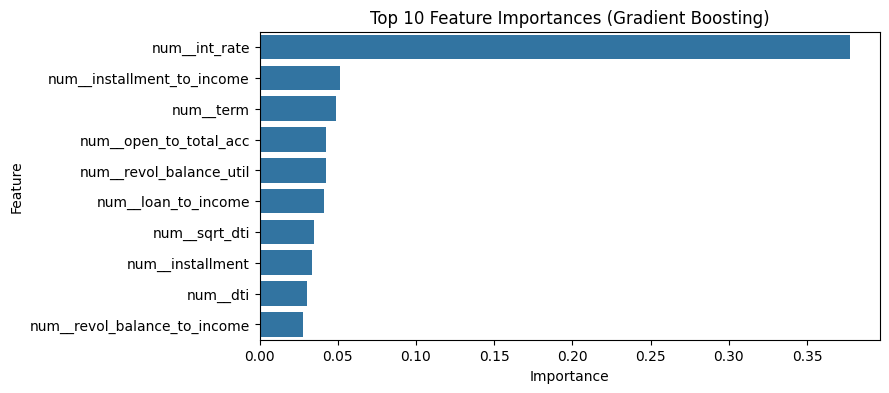

In [ ]:
gb_feature_names = gb_best_pipeline.named_steps["preprocess"].get_feature_names_out()
gb_importances = gb_best_pipeline.named_steps["model"].feature_importances_

gb_importance_df = pd.DataFrame(
    {"feature": gb_feature_names, "importance": gb_importances}
).sort_values("importance", ascending=False)

plt.figure(figsize=(8, 4))
sns.barplot(
    x="importance",
    y="feature",
    data=gb_importance_df.head(10),
    orient="h",
)
plt.title("Top 10 Feature Importances (Gradient Boosting)")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()


## Model Comparison


In [ ]:
comparison_df = results_df[
    ["Model", "Train_AUC", "Val_AUC", "AUC_Gap", "Train_RMSE", "Val_RMSE", "RMSE_Gap"]
].copy()

comparison_df[["Train_AUC", "Val_AUC", "AUC_Gap", "Train_RMSE", "Val_RMSE", "RMSE_Gap"]] = (
    comparison_df[["Train_AUC", "Val_AUC", "AUC_Gap", "Train_RMSE", "Val_RMSE", "RMSE_Gap"]].round(6)
)

comparison_df = comparison_df.sort_values("Val_AUC", ascending=False).reset_index(drop=True)
comparison_df


The model with the highest validation AUC is selected as the leading candidate. The AUC_Gap column highlights overfitting risk: larger gaps indicate stronger train–validation divergence. RMSE values provide a probability calibration check; small RMSE_Gap values suggest stable generalization. Overall improvements are modest but consistent with credit‑risk modeling norms.


We select the final model for business thresholding based on validation AUC.


In [ ]:
FINAL_MODEL_NAME = comparison_df.loc[0, "Model"]

FINAL_PIPELINE = {
    "Logistic Regression": log_reg_pipeline,
    "Decision Tree": best_tree_pipeline,
    "Random Forest": rf_best_pipeline,
    "Gradient Boosting": gb_best_pipeline,
}[FINAL_MODEL_NAME]

FINAL_MODEL_NAME


## Threshold Optimization (Business)

Machine learning models output probabilities, but lending decisions require a classification threshold to approve or reject applicants. The optimal threshold depends on the business costs and benefits of each decision outcome.


### Business Assumptions

Because no monetary cost-benefit values are provided, we use a reasonable illustrative payoff matrix:

- True Negative (Approve loan, borrower repays): +1
- False Positive (Reject loan, borrower would repay): -1
- False Negative (Approve loan, borrower defaults): -5
- True Positive (Reject loan, borrower would default): 0

Defaults are much more costly than missed opportunities, so the policy is intentionally conservative. These values are illustrative but economically reasonable for decision-making.


In [37]:
y_val_proba = gb_pipeline.predict_proba(X_val)[:, 1]

thresholds = np.linspace(0.01, 0.99, 99)

results_threshold = []

for threshold in thresholds:
    y_pred = (y_val_proba >= threshold).astype(int)

    tp = ((y_val == 1) & (y_pred == 1)).sum()
    fp = ((y_val == 0) & (y_pred == 1)).sum()
    fn = ((y_val == 1) & (y_pred == 0)).sum()
    tn = ((y_val == 0) & (y_pred == 0)).sum()

    expected_value = (tn * 1) + (fp * -1) + (fn * -5) + (tp * 0)

    results_threshold.append(
        {
            "threshold": threshold,
            "expected_value": expected_value,
            "TP": tp,
            "FP": fp,
            "FN": fn,
            "TN": tn,
        }
    )

threshold_df = pd.DataFrame(results_threshold)

best_idx = threshold_df["expected_value"].idxmax()
best_threshold = threshold_df.loc[best_idx, "threshold"]
best_expected_value = threshold_df.loc[best_idx, "expected_value"]

best_threshold, best_expected_value


(np.float64(0.26), np.int64(-71))

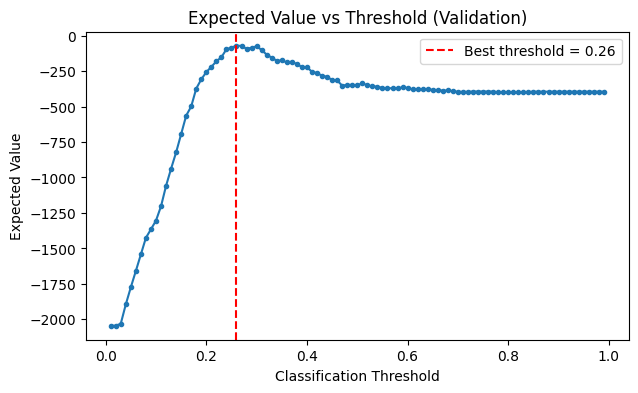

In [38]:
plt.figure(figsize=(7, 4))
plt.plot(threshold_df["threshold"], threshold_df["expected_value"], marker="o", markersize=3)
plt.axvline(best_threshold, color="red", linestyle="--", label=f"Best threshold = {best_threshold:.2f}")
plt.title("Expected Value vs Threshold (Validation)")
plt.xlabel("Classification Threshold")
plt.ylabel("Expected Value")
plt.legend()
plt.show()


**Interpretation**

The optimal threshold from the validation expected-value curve (reported above) reflects a more conservative lending policy, because default costs are much larger than missed repayment opportunities. If default costs were lower or opportunity costs higher, the optimal threshold would shift downward to approve more loans.


## Final Test Evaluation

Final test evaluation is intentionally deferred to preserve an unbiased hold‑out set.


## Conclusion

This notebook follows the full supervised learning workflow for credit risk, with clear separation between exploration, modeling, and business decisioning.
